In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib

In [13]:
# Load dataset penjualan dari CSV
df = pd.read_csv('dataset_penjualan.csv')

print("Sample data Order Date sebelum konversi:")
print(df['Order Date'].head(10).tolist())

# Konversi kolom Order Date ke datetime dengan format mixed dan dayfirst
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', dayfirst=True)

print("\nSample data Order Date setelah konversi:")
print(df['Order Date'].head(10).tolist())

# Agregasi data penjualan per hari
df_daily = df.groupby('Order Date')['Sales'].sum().reset_index()
df_daily.set_index('Order Date', inplace=True)

# Sort berdasarkan tanggal
df_daily = df_daily.sort_index()

print("\nInformasi Dataset:")
print(f"Jumlah data: {len(df_daily)}")
print(f"Tanggal awal: {df_daily.index.min()}")
print(f"Tanggal akhir: {df_daily.index.max()}")
print("\n5 data pertama:")
print(df_daily.head())
print("\n5 data terakhir:")
print(df_daily.tail())

Sample data Order Date sebelum konversi:
['08/11/2017', '08/11/2017', '12/06/2017', '11/10/2016', '11/10/2016', '09/06/2015', '09/06/2015', '09/06/2015', '09/06/2015', '09/06/2015']

Sample data Order Date setelah konversi:
[Timestamp('2017-11-08 00:00:00'), Timestamp('2017-11-08 00:00:00'), Timestamp('2017-06-12 00:00:00'), Timestamp('2016-10-11 00:00:00'), Timestamp('2016-10-11 00:00:00'), Timestamp('2015-06-09 00:00:00'), Timestamp('2015-06-09 00:00:00'), Timestamp('2015-06-09 00:00:00'), Timestamp('2015-06-09 00:00:00'), Timestamp('2015-06-09 00:00:00')]

Informasi Dataset:
Jumlah data: 1230
Tanggal awal: 2015-01-03 00:00:00
Tanggal akhir: 2018-12-30 00:00:00

5 data pertama:
               Sales
Order Date          
2015-01-03    16.448
2015-01-04   288.060
2015-01-05    19.536
2015-01-06  4407.100
2015-01-07    87.158

5 data terakhir:
                Sales
Order Date           
2018-12-26   814.5940
2018-12-27   177.6360
2018-12-28  1657.3508
2018-12-29  2915.5340
2018-12-30   7

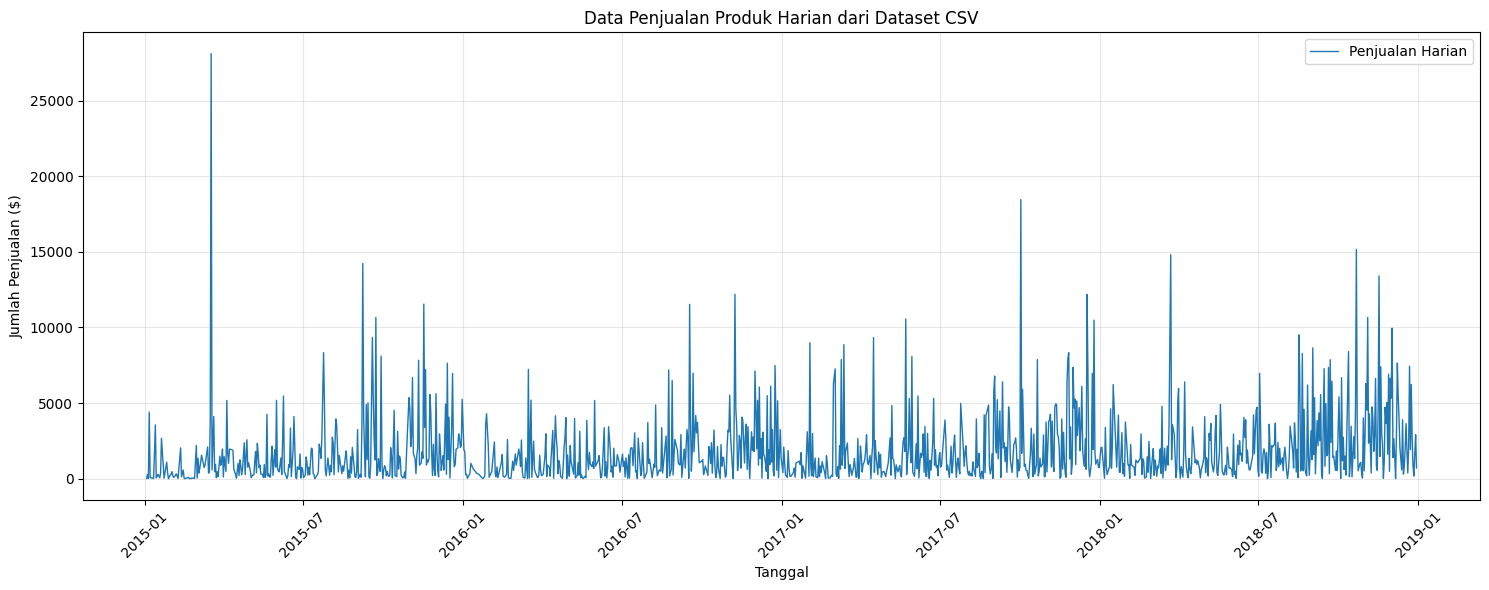


Statistik Data Penjualan:
Rata-rata penjualan harian: $1838.65
Median penjualan harian: $1058.40
Penjualan tertinggi: $28106.72
Penjualan terendah: $2.02
Standar deviasi: $2295.42


In [14]:
plt.figure(figsize=(15,6))
plt.plot(df_daily.index, df_daily['Sales'], label='Penjualan Harian', linewidth=1)
plt.title('Data Penjualan Produk Harian dari Dataset CSV')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Penjualan ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tampilkan statistik dasar
print("\nStatistik Data Penjualan:")
print(f"Rata-rata penjualan harian: ${df_daily['Sales'].mean():.2f}")
print(f"Median penjualan harian: ${df_daily['Sales'].median():.2f}")
print(f"Penjualan tertinggi: ${df_daily['Sales'].max():.2f}")
print(f"Penjualan terendah: ${df_daily['Sales'].min():.2f}")
print(f"Standar deviasi: ${df_daily['Sales'].std():.2f}")

In [15]:
# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_daily[['Sales']])

print(f"Data asli shape: {df_daily.shape}")
print(f"Data scaled shape: {scaled_data.shape}")

# Membuat data sekuens (60 hari sebelumnya -> prediksi hari ke-61)
timesteps = 60
X, y = [], []
for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data[i-timesteps:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Bentuk data menjadi [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(f"\nData untuk training:")
print(f"X shape: {X.shape} (samples, timesteps, features)")
print(f"y shape: {y.shape} (target values)")
print(f"Total samples untuk training: {X.shape[0]}")
print(f"Timesteps (hari sebelumnya): {X.shape[1]}")
print(f"Features: {X.shape[2]}")

Data asli shape: (1230, 1)
Data scaled shape: (1230, 1)

Data untuk training:
X shape: (1170, 60, 1) (samples, timesteps, features)
y shape: (1170,) (target values)
Total samples untuk training: 1170
Timesteps (hari sebelumnya): 60
Features: 1


In [16]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
model = Sequential([
LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
Dropout(0.2),
LSTM(100, return_sequences=False),
Dropout(0.2),
Dense(50, activation='relu'),
Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Setup Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Stop jika tidak ada improvement selama 10 epoch
    restore_best_weights=True, # Restore bobot terbaik
    verbose=1                  # Tampilkan pesan ketika early stopping aktif
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Tambahkan early stopping callback
    verbose=1
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0052 - val_loss: 0.0076
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0061 - val_loss: 0.0078
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0

In [19]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"\nNilai RMSE Model: {rmse:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

Nilai RMSE Model: 2446.66


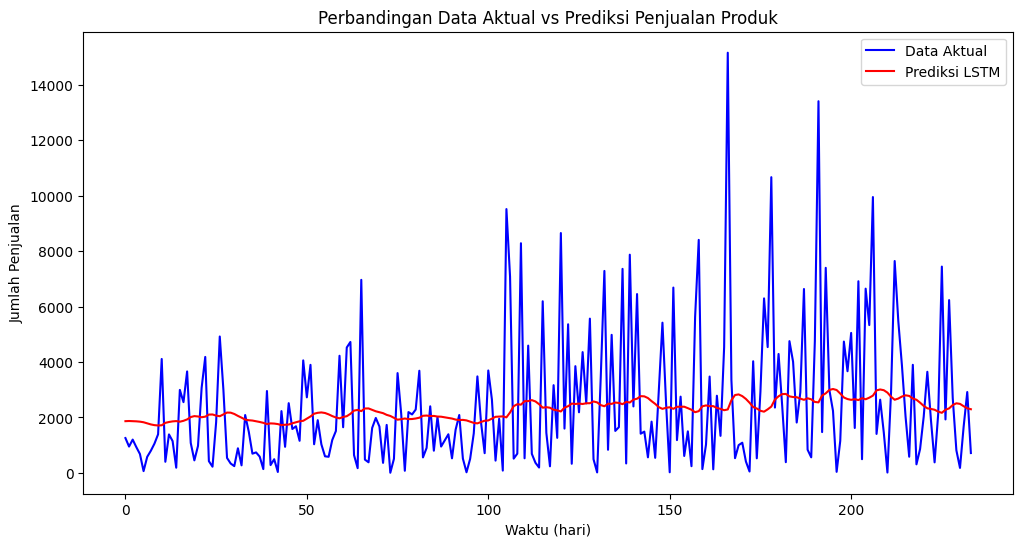

In [20]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, color='blue', label='Data Aktual')
plt.plot(predictions, color='red', label='Prediksi LSTM')
plt.title('Perbandingan Data Aktual vs Prediksi Penjualan Produk')
plt.xlabel('Waktu (hari)')
plt.ylabel('Jumlah Penjualan')
plt.legend()
plt.show()

In [21]:
model.save('model_penjualan_lstm.h5')
joblib.dump(scaler, 'scaler_penjualan.pkl')


print("\nModel dan scaler berhasil disimpan!")


Model dan scaler berhasil disimpan!
